In [2]:
%matplotlib inline
import numpy as np
from scipy.stats import gamma
import matplotlib.pyplot as plt

In [3]:
# taken from https://github.com/nistats/nistats/blob/master/nistats/hemodynamic_models.py
def _gamma_difference_hrf(tr, oversampling=50, time_length=32., onset=0.,
                          delay=6, undershoot=16., dispersion=1.,
                          u_dispersion=1., ratio=0.167):
    """ Compute an hrf as the difference of two gamma functions
    Parameters
    ----------
    tr : float
        scan repeat time, in seconds
    oversampling : int, optional (default=50)
        temporal oversampling factor
    time_length : float, optional (default=32)
        hrf kernel length, in seconds
    onset: float
        onset time of the hrf
    delay: float, optional
        delay parameter of the hrf (in s.)
    undershoot: float, optional
        undershoot parameter of the hrf (in s.)
    dispersion : float, optional
        dispersion parameter for the first gamma function
    u_dispersion : float, optional
        dispersion parameter for the second gamma function
    ratio : float, optional
        ratio of the two gamma components
    Returns
    -------
    hrf : array of shape(length / tr * oversampling, dtype=float)
         hrf sampling on the oversampled time grid
    """
    dt = tr / oversampling
    time_stamps = np.linspace(0, time_length, np.rint(float(time_length) / dt).astype(np.int))
    time_stamps -= onset
    hrf = gamma.pdf(time_stamps, delay / dispersion, dt / dispersion) -\
        ratio * gamma.pdf(
        time_stamps, undershoot / u_dispersion, dt / u_dispersion)
    hrf /= hrf.sum()
    return hrf

## Modelling the BOLD (Blood Oxygen Dependent Response)

We use a double gamma function, which amounts to subtracting one gamma function (the undershoot) from the other (the overcompensation).

We use the probability density function from scipy as [documented in scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gamma.html).

The gamma function can be simplified to `(n-1)!`, and you can read [this paper](https://imsc.uni-graz.at/gronau/TMCS_1_2003.pdf) to try to get an intuition of how the gamma function operates

In [16]:
# time of repetition for simulated scan
tr = 2
# creating the gamma function
tst_gamma = _gamma_difference_hrf(tr, oversampling=1)

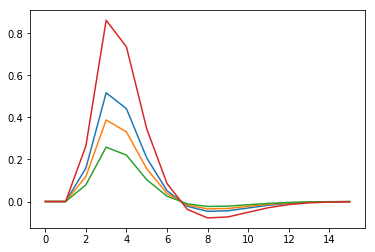

In [17]:
# when estimating betas, we really only have control of height of the function
# we are essentially scaling an array of numbers (the gamma function) by a number (e.g. 1.2, 0.9, 0.6, 2.0)
# 
betas = [1.2, 0.9, 0.6, 2.0]
for beta in betas:
    plt.plot(tst_gamma * beta)

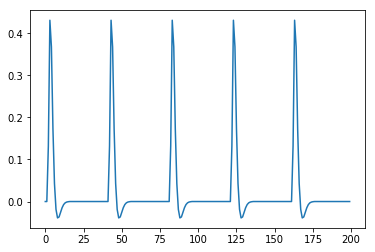

In [19]:
# here is an example of what simulated brain output would be from a task
# time_points
tp = 200
ix = np.arange(tp)
# create voxel timeseries
task_onsets = np.zeros(tp)
# add activations at every 40 time points
task_onsets[0::40] = 1
signal = np.convolve(task_onsets, tst_gamma)[0:len(task_onsets)]

plt.plot(signal)